In [1]:
import sigopt
import os
import numpy as np
import logging
import deeptime.markov.msm as dm
import tqdm.auto as tqdm
import mr_toolkit.trajectory_analysis.traj_analysis as ta
from mr_toolkit.reweighting.analysis import get_set_kls
import synd.core
from mr_toolkit.reweighting import analysis as rwa
import matplotlib.pyplot as plt
from scipy.stats import entropy

/home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[17:02:27] INFO     Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing    ]8;id=237255;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=496774;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py#148\148]8;;\
                    safe limit of 8.                                                                               

           INFO     NumExpr defaulting to 8 threads.                                                   ]8;id=617906;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=24261;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/numexpr/utils.py#160\160]8;;\

           WARNING  msm_we not found, fpt_distribution calculations will be unavailable              ]8;id=221003;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/reweighting/analysis.py\analysis.py]8;;\:]8;id=877110;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/reweighting/analysis.py#18\18]8;;\

# Hyperparameter optimization with SigOpt

To build a reweighted MSM using a given set of trajectories, there are a number of sensitive hyperparameters.
These include:
- MSM lagtime
- Fragment length
- Last-fraction of trajectories to use

Besides lagtime, it's not necessarily clear how to choose these.

This notebook demonstrates a heuristic optimization approach that works by splitting up the input dataset into subsets, and identifying the hyperparameters that provide maximal similarity across subsets.
This assumes that self-consistency across subsets means we're getting reasonably consistent estimates.

In [2]:
n_trajectories = 200
trajectory_length = 100

n_subsets = 4

# From the underlying model
n_states = 100

First, verify an API key is stored in the environment. To get an API key for sigopt, [register for an account](https://app.sigopt.com/signup) and then visit [the token page](https://app.sigopt.com/tokens/info).

In [3]:
if os.environ.get('SIGOPT_API_TOKEN', None) is None:
    raise Exception('Set $SIGOPT_API_TOKEN in your environment to use this notebook.')

Then create the sigopt project, or use the existing one.

In [4]:
if 'SIGOPT_PROJECT' not in os.environ.keys():

    project_name = 'sample_optimization'
    
    print(f'$SIGOPT_PROJECT not set in environment -- creating a new project named {project_name}.')

    try:
        sigopt.create_project(project_name)
    except sigopt.factory.ConflictingProjectException as e:
        print("Sigopt project already exists, using that.")

    os.environ['SIGOPT_PROJECT'] = project_name

$SIGOPT_PROJECT not set in environment -- creating a new project named {project_name}.
Sigopt project already exists, using that.


## Generate sample data

In [5]:
state_definitions = np.load('sample_data/coarser-state_definitions.npz')

source_states = state_definitions['source']
target_states = state_definitions['target']

In [6]:
synd_model = synd.core.load_model('sample_data/coarser-model.synd')

In [7]:
ref_equil = np.load('sample_data/coarser-reference_distributions.npz')['equil']

In [8]:
initial_points = np.array([source_states[0] for x in range(n_trajectories)])

trajectories = synd_model.generate_trajectory(
    initial_states = initial_points,
    n_steps = trajectory_length
)

## Split data into subsets

First, let's split our data up into equal-size subsets.

In [9]:
datasets = np.array([trajectories[i::n_subsets] for i in range(n_subsets)])

## Test parameters on subsets to identify optimal

Now, we'll run a Sigopt experiment to identify the "optimal" set of parameters.

In [10]:
metaparameters = dict(
    trajectory_length=trajectory_length,
    n_trajectories_per_set=n_trajectories // n_subsets,
    n_trajectory_sets=n_subsets,
    
    # These below probably won't change much
    min_weight=1e-12,  # This just helps with numerical stability during the reweighting iteration
    last_frac=1.0,
    n_reweight_iters=100,
)

### Define parameter space

In [11]:
experiment = sigopt.create_experiment(
        name=f"Sample optimization",
        budget=3,
        parameters=[
            dict(name='N', 
                 type='int', 
                 bounds={'min': 2, 'max': metaparameters['trajectory_length']-1 }),
            
            # dict(name='last_frac', 
            #      type='double', 
            #      bounds={'min': 0.25, 'max': 1.0 }),
            
            dict(name='lag', 
                 type='int', 
                 bounds={'min': 1, 'max': metaparameters['trajectory_length']-5 }),
        ],
        metrics=[
            {
                "name": "lag_vs_N",
                "strategy": "constraint",
                "objective": "minimize",
                "threshold": 1.0,
            },
            {
                "name": "avg_set_iterative_kl",
                "strategy": "optimize",
                "objective": "minimize",
            },
        ],
        metadata=metaparameters,
    )

[17:02:28] INFO     AI Experiment created, view it on the SigOpt dashboard at                         ]8;id=447684;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/factory.py\factory.py]8;;\:]8;id=768683;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/factory.py#54\54]8;;\
                    https://app.sigopt.com/aiexperiment/570837                                                     

## Perform optimization

In [12]:
for run in tqdm.tqdm(experiment.loop(), desc='SigOpt Run'):
    with run:
        
        # Lag time must be shorter than N, so this must be below 1
        lag_vs_N = run.params["lag"] / run.params["N"]
        run.log_metric("lag_vs_N", lag_vs_N)
        if lag_vs_N >= 1.0:
            print("Invalid lag / N combination, skipping to next run")
            continue
            
        # Estimate reweighted equilibrium for each set
        reweighted_equil_estimates = np.full((n_subsets, n_states), fill_value=np.nan)
        
        for i, trajectory_set in enumerate(datasets):
            
            (states, stationaries, last_iter, reweighted_matrices,) = rwa.compute_reweighted_stationary(
                trajectory_set,
                N=run.params["N"],
                lag=run.params["lag"],
                n_clusters=n_states,
                n_reweighting_iters=metaparameters['n_reweight_iters'],
                min_weight=metaparameters['min_weight'],
                last_frac=metaparameters['last_frac'],
            )
            
            print(last_iter)
            
            reweighted_equil_estimates[i] = stationaries[last_iter]
        
        mean_kl = get_set_kls(reweighted_equil_estimates)
        
        if np.isnan(mean_kl):
            mean_kl = 10
    
        # Log set-set KL divergence
        run.log_metric('avg_set_iterative_kl', mean_kl)

SigOpt Run: 0it [00:00, ?it/s]

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=272781;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=379732;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/603735                                                              


Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 54623.91it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]

           WARNING  Stationary solution 1 is all in one bin in iter 0 -- picking next-biggest  ]8;id=199108;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=351432;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is not positive semidefinite, trying the next one    ]8;id=60396;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=923811;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 3 is not positive semidefinite, trying the next one    ]8;id=899961;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=985265;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 4 is not positive semidefinite, trying the next one    ]8;id=170953;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=773833;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 5 is not positive semidefinite, trying the next one    ]8;id=918899;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=387831;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 6 is not positive semidefinite, trying the next one    ]8;id=288114;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=10185;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 7 is not positive semidefinite, trying the next one    ]8;id=10020;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=387966;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 8 is not positive semidefinite, trying the next one    ]8;id=752342;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=707307;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 9 is not positive semidefinite, trying the next one    ]8;id=983533;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=328780;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 10 is not positive semidefinite, trying the next one   ]8;id=737273;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=897902;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 11 is not positive semidefinite, trying the next one   ]8;id=420822;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=565805;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 12 is not positive semidefinite, trying the next one   ]8;id=16012;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=135422;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 13 is not positive semidefinite, trying the next one   ]8;id=727049;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=326710;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 14 is not positive semidefinite, trying the next one   ]8;id=357390;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=881522;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 15 is not positive semidefinite, trying the next one   ]8;id=192990;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=689429;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 16 is not positive semidefinite, trying the next one   ]8;id=82142;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=929051;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 17 is not positive semidefinite, trying the next one   ]8;id=665001;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=977559;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 18 is not positive semidefinite, trying the next one   ]8;id=642108;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=977848;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 19 is not positive semidefinite, trying the next one   ]8;id=50069;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=357669;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 20 is not positive semidefinite, trying the next one   ]8;id=514264;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=139220;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 21 is not positive semidefinite, trying the next one   ]8;id=678445;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=417772;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 22 is not positive semidefinite, trying the next one   ]8;id=507352;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=559665;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 23 is not positive semidefinite, trying the next one   ]8;id=606917;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=153726;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 24 is not positive semidefinite, trying the next one   ]8;id=797797;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=502725;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 25 is not positive semidefinite, trying the next one   ]8;id=445611;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=477956;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 26 is not positive semidefinite, trying the next one   ]8;id=769114;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=450623;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 27 is not positive semidefinite, trying the next one   ]8;id=336422;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=492323;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 28 is not positive semidefinite, trying the next one   ]8;id=553549;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=564824;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 29 is not positive semidefinite, trying the next one   ]8;id=727361;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=383268;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 30 is not positive semidefinite, trying the next one   ]8;id=583438;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=95147;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 31 is not positive semidefinite, trying the next one   ]8;id=758712;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=89067;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 32 is not positive semidefinite, trying the next one   ]8;id=177028;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=234796;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 33 is not positive semidefinite, trying the next one   ]8;id=499496;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=137726;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 34 is not positive semidefinite, trying the next one   ]8;id=821963;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=782448;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 35 is not positive semidefinite, trying the next one   ]8;id=494011;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=92438;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 36 is not positive semidefinite, trying the next one   ]8;id=585221;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=612599;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 37 is all in one bin in iter 0 -- picking next-biggest ]8;id=826826;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=210733;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is not positive semidefinite, trying the next one   ]8;id=894104;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=533776;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 39 is not positive semidefinite, trying the next one   ]8;id=486301;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=733043;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 40 is all in one bin in iter 0 -- picking next-biggest ]8;id=239446;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=674315;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 0 -- picking next-biggest ]8;id=285455;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=487963;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 0 -- picking next-biggest ]8;id=313434;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=118182;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 0 -- picking next-biggest ]8;id=793700;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=695011;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 0 -- picking next-biggest ]8;id=776775;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=71706;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 0 -- picking next-biggest ]8;id=190648;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=414010;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is not positive semidefinite, trying the next one   ]8;id=527506;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=459558;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 47 is not positive semidefinite, trying the next one   ]8;id=839085;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=387643;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 48 is not positive semidefinite, trying the next one   ]8;id=430708;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=441311;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 49 is not positive semidefinite, trying the next one   ]8;id=325102;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=8945;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 50 is all in one bin in iter 0 -- picking next-biggest ]8;id=421050;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=944462;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 0 -- picking next-biggest ]8;id=613152;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=383660;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 0 -- picking next-biggest ]8;id=221172;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=32330;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 0 -- picking next-biggest ]8;id=977184;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=963156;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 0 -- picking next-biggest ]8;id=400143;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=146022;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 0 -- picking next-biggest ]8;id=203691;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=546644;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 0 -- picking next-biggest ]8;id=663347;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=608771;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

/home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py:480: RuntimeWarning: divide by zero encountered in divide
  stationary = np.real(evecs[:, max_eig_index]) / np.real(
/home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py:480: RuntimeWarning: invalid value encountered in divide
  stationary = np.real(evecs[:, max_eig_index]) / np.real(
Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]


           ERROR    Stationary distribution not normalized in iter 0!                                ]8;id=605984;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/reweighting/analysis.py\analysis.py]8;;\:]8;id=925237;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/reweighting/analysis.py#86\86]8;;\

0



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 58774.99it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]

           WARNING  Stationary solution 1 is all in one bin in iter 1 -- picking next-biggest  ]8;id=951531;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=577129;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 2 is all in one bin in iter 1 -- picking next-biggest  ]8;id=894197;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=74049;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 3 is all in one bin in iter 1 -- picking next-biggest  ]8;id=25014;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=401060;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 4 is all in one bin in iter 1 -- picking next-biggest  ]8;id=16375;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=879248;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 5 is all in one bin in iter 1 -- picking next-biggest  ]8;id=806231;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=431691;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 6 is all in one bin in iter 1 -- picking next-biggest  ]8;id=633589;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=856172;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 7 is all in one bin in iter 1 -- picking next-biggest  ]8;id=44320;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=832800;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 8 is all in one bin in iter 1 -- picking next-biggest  ]8;id=434032;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=626125;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 9 is all in one bin in iter 1 -- picking next-biggest  ]8;id=887321;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=895449;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 10 is all in one bin in iter 1 -- picking next-biggest ]8;id=592108;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=520716;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 11 is all in one bin in iter 1 -- picking next-biggest ]8;id=8007;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=619759;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 12 is all in one bin in iter 1 -- picking next-biggest ]8;id=406838;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=92809;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 13 is all in one bin in iter 1 -- picking next-biggest ]8;id=518741;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=873029;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 14 is all in one bin in iter 1 -- picking next-biggest ]8;id=769591;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=412462;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 15 is all in one bin in iter 1 -- picking next-biggest ]8;id=674320;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=427353;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 16 is all in one bin in iter 1 -- picking next-biggest ]8;id=864199;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=832891;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 17 is all in one bin in iter 1 -- picking next-biggest ]8;id=548704;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=148503;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 18 is all in one bin in iter 1 -- picking next-biggest ]8;id=892016;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=14929;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 19 is not positive semidefinite, trying the next one   ]8;id=333720;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=363894;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 20 is all in one bin in iter 1 -- picking next-biggest ]8;id=523977;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=374775;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 21 is all in one bin in iter 1 -- picking next-biggest ]8;id=80371;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=446943;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 22 is all in one bin in iter 1 -- picking next-biggest ]8;id=549496;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=122530;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 23 is all in one bin in iter 1 -- picking next-biggest ]8;id=691271;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=426873;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 24 is all in one bin in iter 1 -- picking next-biggest ]8;id=576400;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=717608;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 25 is all in one bin in iter 1 -- picking next-biggest ]8;id=270612;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=519623;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 26 is all in one bin in iter 1 -- picking next-biggest ]8;id=781219;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=492831;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 27 is all in one bin in iter 1 -- picking next-biggest ]8;id=347471;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=446659;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 28 is all in one bin in iter 1 -- picking next-biggest ]8;id=412581;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=458241;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 29 is all in one bin in iter 1 -- picking next-biggest ]8;id=985293;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=877321;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 30 is all in one bin in iter 1 -- picking next-biggest ]8;id=918097;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=350673;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 31 is all in one bin in iter 1 -- picking next-biggest ]8;id=637559;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=319285;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 32 is all in one bin in iter 1 -- picking next-biggest ]8;id=458402;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=346046;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 33 is all in one bin in iter 1 -- picking next-biggest ]8;id=654710;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=109761;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 34 is all in one bin in iter 1 -- picking next-biggest ]8;id=967343;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=140965;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 35 is all in one bin in iter 1 -- picking next-biggest ]8;id=316530;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=645467;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 36 is all in one bin in iter 1 -- picking next-biggest ]8;id=206317;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=224306;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 37 is all in one bin in iter 1 -- picking next-biggest ]8;id=128078;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=572367;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 38 is all in one bin in iter 1 -- picking next-biggest ]8;id=747904;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=597319;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 39 is all in one bin in iter 1 -- picking next-biggest ]8;id=822827;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=918120;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 40 is all in one bin in iter 1 -- picking next-biggest ]8;id=463939;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=803037;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 41 is all in one bin in iter 1 -- picking next-biggest ]8;id=708377;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=468755;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 42 is all in one bin in iter 1 -- picking next-biggest ]8;id=809274;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=577148;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 43 is all in one bin in iter 1 -- picking next-biggest ]8;id=236180;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=15010;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 44 is all in one bin in iter 1 -- picking next-biggest ]8;id=742450;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=360509;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 45 is all in one bin in iter 1 -- picking next-biggest ]8;id=286335;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=63902;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 46 is not positive semidefinite, trying the next one   ]8;id=739306;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=859605;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           WARNING  Stationary solution 47 is all in one bin in iter 1 -- picking next-biggest ]8;id=536868;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=969397;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 48 is all in one bin in iter 1 -- picking next-biggest ]8;id=520043;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=877800;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 49 is all in one bin in iter 1 -- picking next-biggest ]8;id=424331;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=478952;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 50 is all in one bin in iter 1 -- picking next-biggest ]8;id=592464;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=13952;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 51 is all in one bin in iter 1 -- picking next-biggest ]8;id=345998;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=934038;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 52 is all in one bin in iter 1 -- picking next-biggest ]8;id=789459;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=517764;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 53 is all in one bin in iter 1 -- picking next-biggest ]8;id=748602;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=95046;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 54 is all in one bin in iter 1 -- picking next-biggest ]8;id=345256;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=991344;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 55 is all in one bin in iter 1 -- picking next-biggest ]8;id=396042;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=315931;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 56 is all in one bin in iter 1 -- picking next-biggest ]8;id=654848;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=392118;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 57 is all in one bin in iter 1 -- picking next-biggest ]8;id=511105;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=290165;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 58 is all in one bin in iter 1 -- picking next-biggest ]8;id=960479;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=290494;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 59 is all in one bin in iter 1 -- picking next-biggest ]8;id=283845;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=657454;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 60 is all in one bin in iter 1 -- picking next-biggest ]8;id=729793;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=126435;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 61 is all in one bin in iter 1 -- picking next-biggest ]8;id=152892;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=448148;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 62 is all in one bin in iter 1 -- picking next-biggest ]8;id=545753;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=776380;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 63 is all in one bin in iter 1 -- picking next-biggest ]8;id=516478;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=108297;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 64 is all in one bin in iter 1 -- picking next-biggest ]8;id=424091;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=571283;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 65 is all in one bin in iter 1 -- picking next-biggest ]8;id=208627;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=97387;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 66 is all in one bin in iter 1 -- picking next-biggest ]8;id=699148;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=281199;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 67 is all in one bin in iter 1 -- picking next-biggest ]8;id=266990;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=177472;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 68 is all in one bin in iter 1 -- picking next-biggest ]8;id=653410;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=95128;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

[17:02:29] WARNING  Stationary solution 69 is all in one bin in iter 1 -- picking next-biggest ]8;id=444815;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=18753;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 70 is all in one bin in iter 1 -- picking next-biggest ]8;id=985248;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=418069;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 71 is all in one bin in iter 1 -- picking next-biggest ]8;id=951630;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=304712;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 72 is all in one bin in iter 1 -- picking next-biggest ]8;id=207692;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=334453;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 73 is all in one bin in iter 1 -- picking next-biggest ]8;id=726067;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=691958;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 74 is all in one bin in iter 1 -- picking next-biggest ]8;id=227771;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=858052;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 75 is all in one bin in iter 1 -- picking next-biggest ]8;id=630331;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=669002;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 76 is all in one bin in iter 1 -- picking next-biggest ]8;id=306113;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=679090;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 77 is all in one bin in iter 1 -- picking next-biggest ]8;id=71606;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=755607;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 78 is all in one bin in iter 1 -- picking next-biggest ]8;id=794802;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=283193;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 79 is all in one bin in iter 1 -- picking next-biggest ]8;id=346735;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=12720;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 80 is all in one bin in iter 1 -- picking next-biggest ]8;id=16456;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=511376;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 81 is all in one bin in iter 1 -- picking next-biggest ]8;id=457068;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=666223;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 82 is all in one bin in iter 1 -- picking next-biggest ]8;id=231907;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=959652;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 83 is all in one bin in iter 1 -- picking next-biggest ]8;id=777693;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=569788;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 84 is all in one bin in iter 1 -- picking next-biggest ]8;id=559340;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=550731;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 85 is all in one bin in iter 1 -- picking next-biggest ]8;id=102514;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=760655;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 86 is all in one bin in iter 1 -- picking next-biggest ]8;id=482129;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=273750;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 87 is all in one bin in iter 1 -- picking next-biggest ]8;id=11243;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=786355;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 88 is all in one bin in iter 1 -- picking next-biggest ]8;id=665666;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=932217;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 89 is all in one bin in iter 1 -- picking next-biggest ]8;id=438388;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=861100;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 90 is all in one bin in iter 1 -- picking next-biggest ]8;id=806086;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=372737;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 91 is all in one bin in iter 1 -- picking next-biggest ]8;id=23141;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=268549;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 92 is all in one bin in iter 1 -- picking next-biggest ]8;id=318207;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=526095;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 93 is all in one bin in iter 1 -- picking next-biggest ]8;id=85010;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=547171;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 94 is all in one bin in iter 1 -- picking next-biggest ]8;id=704400;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=46664;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 95 is all in one bin in iter 1 -- picking next-biggest ]8;id=218286;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=831409;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 96 is all in one bin in iter 1 -- picking next-biggest ]8;id=747238;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=646307;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 97 is all in one bin in iter 1 -- picking next-biggest ]8;id=709510;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=842987;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 98 is all in one bin in iter 1 -- picking next-biggest ]8;id=206729;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=171678;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#476\476]8;;\
                    eigenvalue                                                                                     

           WARNING  Stationary solution 99 is not positive semidefinite, trying the next one   ]8;id=659320;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=192596;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#478\478]8;;\

           CRITICAL No good stationary solution exists! Stopping iteration at iter 1           ]8;id=594170;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py\traj_analysis.py]8;;\:]8;id=202246;file:///home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py#470\470]8;;\

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]


1



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 56096.66it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]/home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py:510: RuntimeWarning: divide by zero encountered in log
  np.log(stationary_distributions[-1]) - np.log(stationary_distributions[-2])
/home/jd/research/reweighting/mr_toolkit/mr_toolkit/mr_toolkit/trajectory_analysis/traj_analysis.py:510: RuntimeWarning: invalid value encountered in subtract
  np.log(stationary_distributions[-1]) - 

reweighted iteration is converged at iter 31
31



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 42485.33it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]
Reweighting convergence: 19it [00:00, 186.11it/s]                                                                                                                                                                                                                                         
Reweighting convergence: 38it [00:00, 180.70it/s]
Reweighting convergence: 57it [00:00, 164.61it/s]
Reweighting convergence: 78it [00:00, 178.60it/s]

99


[17:02:30] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=746779;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=550971;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/603735                                                              

SigOpt Run: 1it [00:02,  2.23s/it]

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=909345;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=828561;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/603736                                                              


Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 58883.55it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]
                                  00, 129.97it/s]                                                                                                                                                                                                                                         
SigOpt Run: 1it [00:03,  2.23s/it]               
Reweighting convergence: 25it [00:00, 123.12it/s]


reweighted iteration is converged at iter 26
26



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 39843.67it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]
                                  00, 115.64it/s]                                                                                                                                                                                                                                         
SigOpt Run: 1it [00:03,  2.23s/it]               
Reweighting convergence: 22it [00:00, 118.85it/s]


reweighted iteration is converged at iter 23
23



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 44090.91it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]
Reweighting convergence:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 8/10.0 [00:00<00:00, 75.19it/s]
                                  00, 94.17it/s]                                                                                                     

reweighted iteration is converged at iter 22
22



Building count matrices: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4100/4100 [00:00<00:00, 45373.62it/s]

Reweighting convergence:   0%|                                                                                                                                                                                                                                   | 0/10.0 [00:00<?, ?it/s]
                                  00, 105.64it/s]                                                                                                                                                                                                                                         
SigOpt Run: 1it [00:03,  2.23s/it]               
Reweighting convergence: 21it [00:00, 103.00it/s]


reweighted iteration is converged at iter 22
22


[17:02:32] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=330918;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=94938;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/603736                                                              

SigOpt Run: 2it [00:04,  2.21s/it]

           INFO     Run started, view it on the SigOpt dashboard at                               ]8;id=464351;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py\run_factory.py]8;;\:]8;id=534588;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_factory.py#13\13]8;;\
                    https://app.sigopt.com/run/603737                                                              

Invalid lag / N combination, skipping to next run


[17:02:33] INFO     Run finished, view it on the SigOpt dashboard at                             ]8;id=804696;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py\run_context.py]8;;\:]8;id=237785;file:///home/jd/anaconda3/envs/mr_toolkit/lib/python3.11/site-packages/sigopt/run_context.py#371\371]8;;\
                    https://app.sigopt.com/run/603737                                                              

SigOpt Run: 3it [00:05,  1.80s/it]


## Analyze global model using optimal parameters

In [14]:
best_run = next(experiment.get_best_runs())

best_N = best_run.assignments["N"]
best_lag = best_run.assignments["lag"]

print(f"Identified optimal fragment length as {best_N} and optimal lag as {best_lag}")

Identified optimal fragment length as 21 and optimal lag as 18


In [15]:
(states, stationaries, last_iter, reweighted_matrices,) = rwa.compute_reweighted_stationary(
    trajectories,
    N=best_N,
    lag=best_lag,
    n_clusters=n_states,
    n_reweighting_iters=metaparameters['n_reweight_iters'],
    min_weight=metaparameters['min_weight'],
    last_frac=metaparameters['last_frac'],
)

reweighted_equil = stationaries[last_iter]

Building count matrices: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16400/16400 [00:00<00:00, 57059.06it/s]
Reweighting convergence: 13it [00:00, 121.65it/s]                                                                                                                                                                                                                                         

reweighted iteration is converged at iter 14


## Compare to standard MSM

In [16]:
msm = dm.MaximumLikelihoodMSM().fit_from_discrete_timeseries(trajectories, best_lag)

msm_equil = msm.fetch_model().stationary_distribution

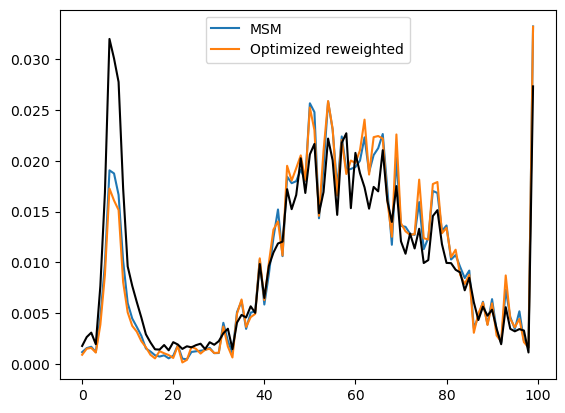

In [17]:
plt.plot(msm_equil, label='MSM')

plt.plot(reweighted_equil, label='Optimized reweighted')

plt.plot(ref_equil, color='k')

plt.legend()

In [18]:
msm_entropy = entropy(msm_equil, ref_equil)
reweighted_entropy = entropy(reweighted_equil, ref_equil)

In [19]:
print("Relative entropies to reference (lower is better)")
print(f"MSM estimate: \t{msm_entropy:.2e}")
print(f"Reweighted estimate: \t{reweighted_entropy:.2e}")

Relative entropies to reference (lower is better)
MSM estimate: 	3.17e-02
Reweighted estimate: 	4.37e-02
